## Sweetpotato Shape Classification

We use a labeled dataset (n=1349) to train classifier that can identify 'Cull' vs. 'U.S. No 1' sweetpotato.
Models to consider -
1. Random Forest
2. Neural Network
3. Gradient Boosting
4. Logistic Regression

The labeled sweetpotato shape feature data is available in 'S3_Data.csv' file. Shape features were calculated using 3D shape reconstruction of sweetpotato images captured using exeter accuvision sorter [See figure for 3D shape example]

In [55]:
from IPython.display import IFrame
IFrame("extracted_features.pdf", width=400, height=500)

## Step1: Load and inspect the data

In [1]:
import pandas as pd
sp_df= pd.read_csv('S3_Data.csv')
sp_df.head()

,Title,AxialLength,TipLength,CurvatuerCorrected,Width,LWRatio,TailLength,TailPct,Shape,BodyLength,...,sdRad20,sdRad21,sdRad22,sdRad23,sdRad24,sdRad25,sdRad26,sdRad27,sdRad28,AverageCrossSectionRoundness
0,18NCGT0014HCR_Beauregard_G2_4001_NIR_V1_O2377.tif,6.603239,6.093776,1.124095,1.850742,2.976498,0.410902,0.062227,U.S. No. 1,6.192337,...,3.804182,3.588049,3.837366,3.525946,4.252956,4.522010,3.477610,2.177427,1.078489,1.806340
1,18NCGT0014HCR_Beauregard_G2_4001_NIR_V1_O2380.tif,5.119064,4.807290,1.099144,1.129356,3.436332,0.853461,0.166722,U.S. No. 1,4.265603,...,0.754751,0.729532,1.011869,1.024671,0.973312,0.988225,1.091580,0.545358,0.276619,0.907820
2,18NCGT0014HCR_Beauregard_G2_4001_NIR_V1_O2383.tif,5.252978,5.075889,1.098599,1.383261,3.068884,0.589353,0.112194,Cull,4.663625,...,1.193471,1.460579,1.181849,1.375172,2.093372,0.852919,0.286649,0.177280,0.175535,0.882446
3,18NCGT0014HCR_Beauregard_G2_5006_NIR_V1_O0260.tif,5.559895,5.228262,1.106817,1.548861,3.017465,0.387037,0.069612,U.S. No. 1,5.172857,...,1.793382,1.965526,1.655876,1.782977,2.319159,4.423387,5.757004,4.401777,2.381559,1.688957
4,18NCGT0014HCR_Beauregard_G2_6003_NIR_V1_O0267.tif,4.630301,4.510832,1.068694,1.494741,2.739946,0.253457,0.054739,U.S. No. 1,4.376844,...,2.052301,1.453204,1.636535,1.632883,1.479650,0.725473,0.676118,0.491355,0.399267,2.234090


Printing column names

In [2]:
sp_df.columns

Index(['Title', 'AxialLength', 'TipLength', 'CurvatuerCorrected', 'Width',
       'LWRatio', 'TailLength', 'TailPct', 'Shape', 'BodyLength',
       'TailBodyRatio', 'Volume', 'diameter1', 'diameter2', 'diameter3',
       'diameter4', 'diameter5', 'diameter6', 'diameter7', 'diameter8',
       'diameter9', 'diameter10', 'diameter11', 'diameter12', 'diameter13',
       'diameter14', 'diameter15', 'diameter16', 'diameter17', 'diameter18',
       'diameter19', 'diameter20', 'diameter21', 'diameter22', 'diameter23',
       'diameter24', 'diameter25', 'diameter26', 'diameter27', 'diameter28',
       'diameter29', 'diameter30', 'diameter31', 'sdRad1', 'sdRad2', 'sdRad3',
       'sdRad4', 'sdRad5', 'sdRad6', 'sdRad7', 'sdRad8', 'sdRad9', 'sdRad10',
       'sdRad11', 'sdRad12', 'sdRad13', 'sdRad14', 'sdRad15', 'sdRad16',
       'sdRad17', 'sdRad18', 'sdRad19', 'sdRad20', 'sdRad21', 'sdRad22',
       'sdRad23', 'sdRad24', 'sdRad25', 'sdRad26', 'sdRad27', 'sdRad28',
       'AverageCrossSectionRoun

We have 72 total variales. Shape is the target variable. Title is the 'id' variable. We have 69 possible predictors. Among this predictors 

1. sdRad1, sdRad2, ... sdRad28 are cross-sectional features (roundness measurement across SP cross sections)[28 total]
2. diameter1, dimaeter2 ... .dimaeter31 are cross-sectional features [31 total]
3. AxialLength, TipLength, CurvatureCorrected, Width, LWRatio, TailLength, TailPct, Shape, BodyLength, TailBodyRatio, Volume, and AverageCrossSectionRoundness are scalar features. [12 Total]

First we will search for co-linearity among the scalar fatures.

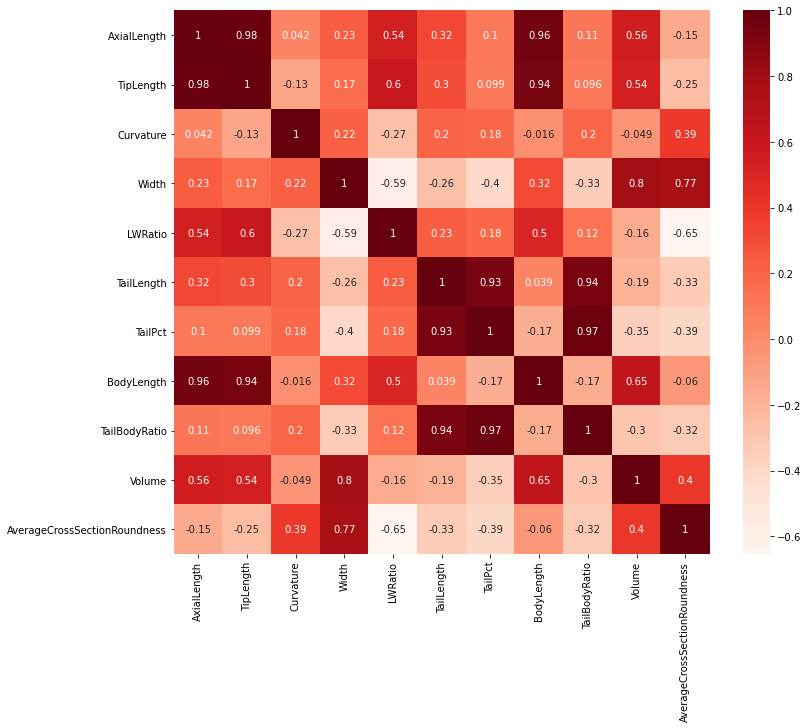

In [3]:
#taking a subset of the dataframe 11 columns 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sp_df = sp_df.rename(columns={'CurvatuerCorrected': 'Curvature'})
df=sp_df[['AxialLength','TipLength','Curvature','Width','LWRatio', 'TailLength', 'TailPct', 'Shape', 'BodyLength', 'TailBodyRatio', 'Volume','AverageCrossSectionRoundness']]
plt.figure(figsize=(12,10))

cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

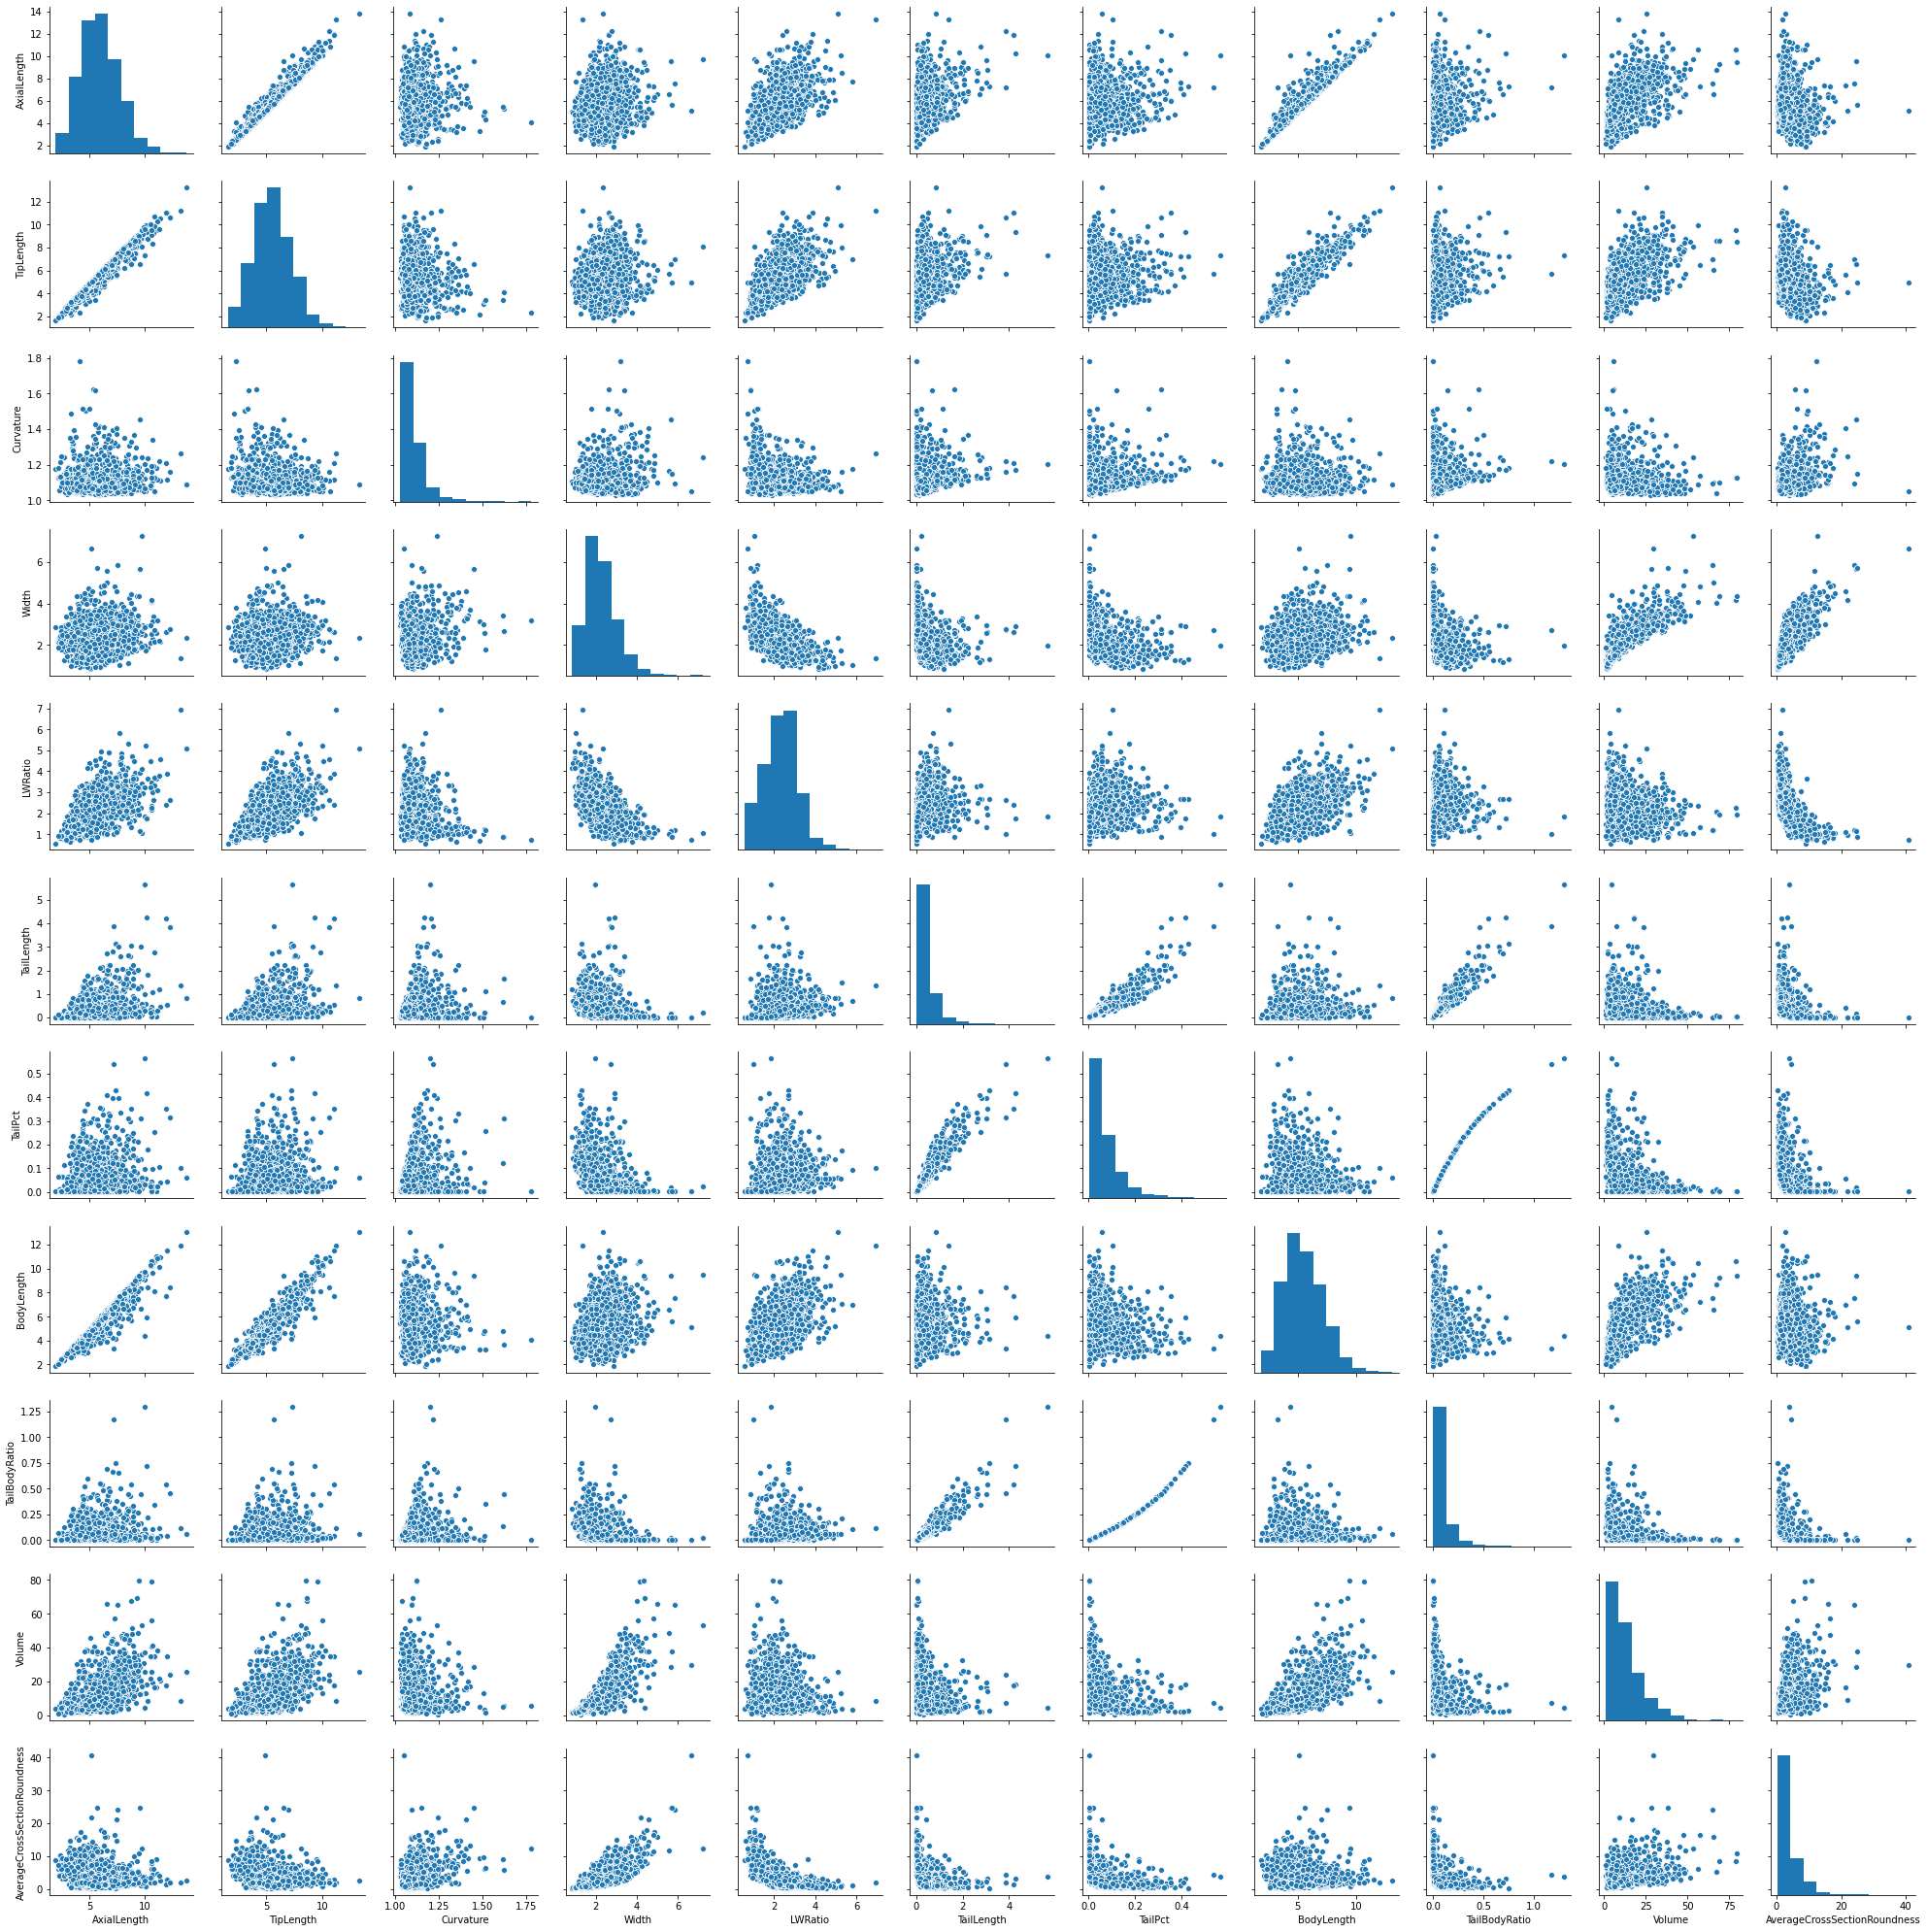

In [4]:
sns.pairplot(df)

We see that following features are highly correlated
1. BodyLength and AxialLength
2. BodyLength and TipLength or StraightLength of SweetPotato
3. TipLenght and AxialLength
4. TailPct and TailBodyRatio
5. TailLength and TailBodyRatio

We drop TailLength, TailLength and BodyLength from the table and recalcaulate the correlation with 9 features

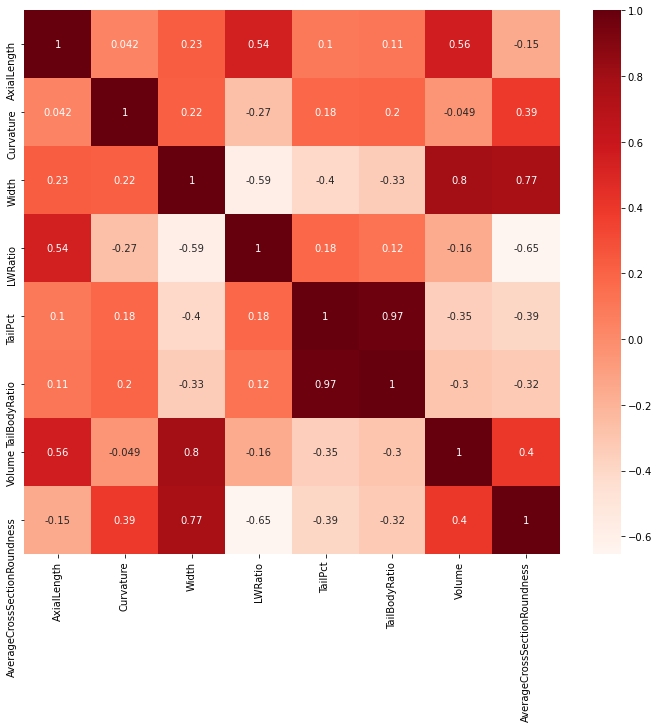

In [8]:
df=df.drop(columns=['TailLength','BodyLength','TipLength'])
plt.figure(figsize=(12,10))

cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

TailPct and TailBodyRatio has high correlation but scatter plot shows that their relationship is non-linear

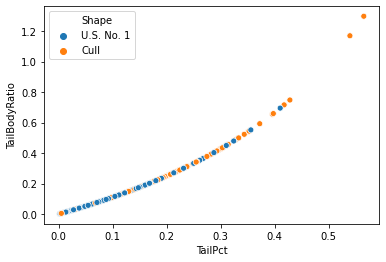

In [9]:
sns.scatterplot(x='TailPct', y='TailBodyRatio', hue='Shape', data=sp_df)


We add the cross-sectional features  and create train test split

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

sp_shape=df['Shape']
sp_features=df.drop(columns=['Shape'])

#add additional columns using pandas concat
sp_features=pd.concat([sp_features.reset_index(drop=True), sp_df.iloc[:,12:71]], axis=1)

#80% training and 20% hold out data
sp_train, sp_test, shape_train, shape_test = train_test_split(sp_features, sp_shape, test_size=0.20, random_state=123,
                                                             stratify=sp_shape)

print(shape_train.value_counts())
print(shape_test.value_counts())



Cull          572
U.S. No. 1    493
Name: Shape, dtype: int64
Cull          143
U.S. No. 1    124
Name: Shape, dtype: int64


In [46]:
sp_features.head()

,AxialLength,Curvature,Width,LWRatio,TailPct,TailBodyRatio,Volume,AverageCrossSectionRoundness,diameter1,diameter2,...,sdRad19,sdRad20,sdRad21,sdRad22,sdRad23,sdRad24,sdRad25,sdRad26,sdRad27,sdRad28
0,6.603239,1.124095,1.850742,2.976498,0.062227,0.066357,9.933092,1.806340,0,0,...,3.354164,3.804182,3.588049,3.837366,3.525946,4.252956,4.522010,3.477610,2.177427,1.078489
1,5.119064,1.099144,1.129356,3.436332,0.166722,0.200080,2.707039,0.907820,0,0,...,0.582737,0.754751,0.729532,1.011869,1.024671,0.973312,0.988225,1.091580,0.545358,0.276619
2,5.252978,1.098599,1.383261,3.068884,0.112194,0.126372,4.051886,0.882446,0,0,...,0.847858,1.193471,1.460579,1.181849,1.375172,2.093372,0.852919,0.286649,0.177280,0.175535
3,5.559895,1.106817,1.548861,3.017465,0.069612,0.074821,6.096857,1.688957,0,0,...,1.743656,1.793382,1.965526,1.655876,1.782977,2.319159,4.423387,5.757004,4.401777,2.381559
4,4.630301,1.068694,1.494741,2.739946,0.054739,0.057909,5.028625,2.234090,0,0,...,2.143880,2.052301,1.453204,1.636535,1.632883,1.479650,0.725473,0.676118,0.491355,0.399267


We see that test and training set has similar distribution of Cull and U.S. No. 1 Sweetpotatoes. 
Now, we select 5-fold cross validation indices for the training set 

In [42]:
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=5,random_state=123,shuffle=True)
print(kf)



#define random forest classifier object
clf = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
#from sklearn.metrics import plot_roc_curve
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores,accuracy = [], [], [],[] #false positive rate, true positive rate, score

print(kf)
for (train, test), i in zip(kf.split(sp_train, shape_train), range(5)):
    clf.fit(sp_train.iloc[train], shape_train.iloc[train])
    #predict and score the validation set
    shape_prediction=clf.predict(sp_train.iloc[test])
    tn, fp, fn, tp=confusion_matrix(shape_train.iloc[test],shape_prediction,labels=['Cull','U.S. No. 1']).ravel()    
    fpr, tpr,=float(fp/(fp+tn)),float(tp/(tp+fn))
    y_pred_proba = clf.predict_proba(sp_train.iloc[test])
    
    auc_score = roc_auc_score(shape_train.iloc[test], y_pred_proba[:,1])   
    acc=accuracy_score(shape_train.iloc[test],shape_prediction)
    
    accuracy.append(acc)
    scores.append(auc_score)
    fprs.append(fpr)
    tprs.append(tpr)

#plot_roc_curve(fprs, tprs);
pd.DataFrame(list(zip(scores,accuracy)), columns=['AUC','Accuracy'])

StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


,AUC,Accuracy
0,0.824135,0.732394
1,0.856877,0.788732
2,0.802144,0.723005
3,0.786284,0.708920
4,0.767145,0.694836


### Now we calculate accruacy on hold out set

0.7303370786516854


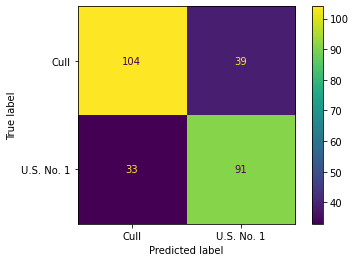

In [44]:
from sklearn.metrics import plot_confusion_matrix
shape_prediction=clf.predict(sp_test)
acc=accuracy_score(shape_test,shape_prediction)
print(acc)
plot_confusion_matrix(clf,sp_test,shape_test)

## We get 73.03% Accuracy with Random Forest Classifier